# Library Imports

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
from pymc import math as pm_math
from scipy.stats import halfnorm, skewnorm

# Model Specification

# Model Specification
## Simulated Data
$$ X \sim N(1,1) $$
$$ U \sim HN(0, \sigma_u^2) $$
$$ Y \sim SN(\xi, \sigma_v^2, \lambda)$$
$$ \xi = \alpha + \beta X - U $$
$$ \alpha = 5, \beta = 2 $$
## Priors
$$ \alpha \sim N(\mu_\alpha, \sigma_\alpha^2) $$
$$ \beta \sim N(\mu_\beta, \sigma_\beta^2) $$
$$ \sigma_v^2 \sim IG(\alpha_v, \beta_v) $$
$$ \sigma_u^2 \sim IG(\alpha_u, \beta_u) $$
$$ \lambda \sim TN(\mu_\lambda, \sigma_\lambda^2; a, b)$$


# Simulate Data: $$ \lambda = -5 $$

# Trace container: Skew

In [2]:
trace_skew = []

# Trace container: Normal

In [3]:
trace_norm = []

# List of sample sizes

In [4]:
sample_size = [50, 100, 200, 500]

# Model Generation: Skew Normal

In [5]:
def skew_norm(sample_size):
    np.random.seed(123)

    # Parameters
    n = sample_size
    alpha = 5
    beta = 2
    sigma_u = 1
    sigma_v = 1.5
    lambda_skew = -5

    # Simulate input X
    X = np.random.normal(1, 1, n)

    # Inefficiency term U ~ HalfNormal(0, sigma_u)
    U = halfnorm(scale=sigma_u).rvs(n)

    # Location ξ = α + βX − U
    xi = alpha + beta * X - U

    # Simulate Y ~ SkewNormal(ξ, sigma_v, lambda_skew)
    Y = skewnorm(a=lambda_skew, loc=xi, scale=sigma_v).rvs(n)

    # Put in DataFrame for convenience
    data = pd.DataFrame({'X': X, 'Y': Y})

    # Generate Model
    with pm.Model() as model:
        # Priors for parameters
        alpha_ = pm.Normal('alpha', mu=5, sigma=5)
        beta_ = pm.Normal('beta', mu=2, sigma=2)
        sigma_u = pm.InverseGamma('sigma_u', alpha=4, beta=3)
        sigma_v = pm.InverseGamma('sigma_v', alpha=2, beta=3)
        lam = pm.TruncatedNormal('lam', mu=-5, sigma=1, lower=-8, upper=-2)

        # Latent inefficiency U ~ HalfNormal(0, sigma_u)
        U = pm.HalfNormal('U', sigma=sigma_u, shape=n)

        # Linear predictor with inefficiency
        mu = alpha_ + beta_ * data['X'] - U

        # Skew-Normal likelihood
        Y_obs = pm.SkewNormal('Y_obs', mu=mu, sigma=sigma_v, alpha=lam, observed=data['Y'])

        # MCMC Sampling
        trace = pm.sample(6000, tune=2000, target_accept=0.99, return_inferencedata=True, compute_covergence_checks=True, idata_kwargs={"log_likelihood": True})
        return model, trace

# Model Generation: Normal

In [6]:
def norm(sample_size):
    np.random.seed(123)

    # Parameters
    n = sample_size
    alpha = 5
    beta = 2
    sigma_u = 1
    sigma_v = 1.5
    lambda_skew = -5

    # Simulate input X
    X = np.random.normal(1, 1, n)

    # Inefficiency term U ~ HalfNormal(0, sigma_u)
    U = halfnorm(scale=sigma_u).rvs(n)

    # Location ξ = α + βX − U
    xi = alpha + beta * X - U

    # Simulate Y ~ SkewNormal(ξ, sigma_v, lambda_skew)
    Y = skewnorm(a=lambda_skew, loc=xi, scale=sigma_v).rvs(n)

    # Put in DataFrame for convenience
    data = pd.DataFrame({'X': X, 'Y': Y})

    # Generate Model
    with pm.Model() as model:
        # Priors for parameters
        alpha_ = pm.Normal('alpha', mu=5, sigma=5)
        beta_ = pm.Normal('beta', mu=2, sigma=2)
        sigma_u = pm.InverseGamma('sigma_u', alpha=4, beta=3)
        sigma_v = pm.InverseGamma('sigma_v', alpha=2, beta=3)
        # lam = pm.TruncatedNormal('lam', mu=-5, sigma=1, lower=-4, upper=0)

        # Latent inefficiency U ~ HalfNormal(0, sigma_u)
        U = pm.HalfNormal('U', sigma=sigma_u, shape=n)

        # Linear predictor with inefficiency
        mu = alpha_ + beta_ * data['X'] - U

        # Normal likelihood
        Y_obs = pm.Normal('Y_obs', mu=mu, sigma=sigma_v, observed=data['Y'])

        # MCMC Sampling
        trace = pm.sample(6000, tune=2000, target_accept=0.99, return_inferencedata=True, compute_covergence_checks=True, idata_kwargs={"log_likelihood": True})
        return model, trace

# Trace Generation: Skew / Normal

In [7]:
sample_size = [50,100,200,500]
for size in sample_size:
    trace_norm.append(norm(size))
    trace_skew.append(skew_norm(size))

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma_u, sigma_v, U]


Output()

Sampling 4 chains for 2_000 tune and 6_000 draw iterations (8_000 + 24_000 draws total) took 14 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma_u, sigma_v, lam, U]


Output()

Sampling 4 chains for 2_000 tune and 6_000 draw iterations (8_000 + 24_000 draws total) took 25 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma_u, sigma_v, U]


Output()

Sampling 4 chains for 2_000 tune and 6_000 draw iterations (8_000 + 24_000 draws total) took 22 seconds.
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma_u, sigma_v, lam, U]


Output()

Sampling 4 chains for 2_000 tune and 6_000 draw iterations (8_000 + 24_000 draws total) took 97 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma_u, sigma_v, U]


Output()

Sampling 4 chains for 2_000 tune and 6_000 draw iterations (8_000 + 24_000 draws total) took 23 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma_u, sigma_v, lam, U]


Output()

Sampling 4 chains for 2_000 tune and 6_000 draw iterations (8_000 + 24_000 draws total) took 48 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma_u, sigma_v, U]


Output()

Sampling 4 chains for 2_000 tune and 6_000 draw iterations (8_000 + 24_000 draws total) took 33 seconds.
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma_u, sigma_v, lam, U]


Output()

Sampling 4 chains for 2_000 tune and 6_000 draw iterations (8_000 + 24_000 draws total) took 145 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


# Posterior Summaries: Skew

Trace Skew 1


mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha    4.71  0.28    4.18     5.23       0.01     0.00   2327.92   6797.43   
beta     2.16  0.13    1.92     2.40       0.00     0.00  13196.07  15323.90   
sigma_u  0.92  0.42    0.30     1.74       0.01     0.01    956.95   1563.38   
sigma_v  1.67  0.32    1.01     2.25       0.01     0.01   1276.78   1209.57   
lam     -3.46  0.44   -4.00    -2.65       0.00     0.00  17098.07  10761.27   
U[0]     0.71  0.54    0.00     1.71       0.01     0.01   2714.52   5907.19   
U[1]     1.22  0.99    0.00     3.14       0.03     0.02   1419.38   2537.16   
U[2]     1.01  0.80    0.00     2.54       0.02     0.01   1597.86   3470.15   
U[3]     1.39  1.16    0.00     3.69       0.03     0.02   1321.43   2437.66   
U[4]     0.19  0.18    0.00     0.52       0.00     0.00  15427.18  10363.52   
U[5]     0.54  0.41    0.00     1.27       0.01     0.00   4964.79   8008.84   
U[6]     0.36  0.30    0.00     0.91       0.00     0.00   6927.10   8266.30   
U[7]     1.23  1.01    0.00     3.23       0.03     0.02   1456.59   2815.43   
U[8]     0.69  0.52    0.00     1.64       0.01     0.01   2898.41   6990.44   
U[9]     1.01  0.80    0.00     2.54       0.02     0.01   1799.73   3202.60   
U[10]    0.53  0.40    0.00     1.25       0.01     0.00   4148.34   6981.75   
U[11]    0.88  0.67    0.00     2.13       0.02     0.01   2056.00   3879.37   
U[12]    0.63  0.47    0.00     1.49       0.01     0.00   3854.10   8590.16   
U[13]    0.65  0.49    0.00     1.54       0.01     0.00   3044.85   6449.15   
U[14]    0.86  0.67    0.00     2.12       0.01     0.01   2245.26   4414.60   
U[15]    0.56  0.42    0.00     1.32       0.01     0.00   4288.31   8023.52   
U[16]    0.92  0.71    0.00     2.25       0.02     0.01   1925.31   4307.75   
U[17]    0.39  0.32    0.00     0.98       0.00     0.00   7236.32   8169.61   
U[18]    1.23  1.00    0.00     3.22       0.03     0.02   1414.61   2565.47   
U[19]    0.98  0.77    0.00     2.46       0.02     0.01   1750.26   3412.65   
U[20]    0.37  0.30    0.00     0.91       0.00     0.00  10390.68  10649.74   
U[21]    0.68  0.50    0.00     1.59       0.01     0.00   3444.83   8386.95   
U[22]    0.56  0.42    0.00     1.33       0.01     0.00   4274.64   7199.56   
U[23]    0.80  0.61    0.00     1.93       0.01     0.01   2087.80   5889.76   
U[24]    1.21  0.99    0.00     3.17       0.03     0.02   1322.83   2284.37   
U[25]    0.65  0.49    0.00     1.55       0.01     0.00   3008.71   5770.40   
U[26]    0.62  0.46    0.00     1.45       0.01     0.00   3428.16   6645.84   
U[27]    0.41  0.32    0.00     0.99       0.00     0.00   7012.21   9879.72   
U[28]    0.61  0.46    0.00     1.45       0.01     0.00   3678.46   7776.99   
U[29]    0.80  0.61    0.00     1.93       0.01     0.01   2255.89   4427.77   
U[30]    0.88  0.68    0.00     2.16       0.02     0.01   1921.26   3936.06   
U[31]    0.79  0.60    0.00     1.91       0.01     0.01   2178.01   4521.13   
U[32]    0.94  0.73    0.00     2.33       0.02     0.01   1831.51   3364.05   
U[33]    0.53  0.40    0.00     1.25       0.01     0.00   4681.68   7609.69   
U[34]    0.64  0.48    0.00     1.51       0.01     0.00   3576.03   7513.23   
U[35]    0.79  0.59    0.00     1.87       0.01     0.01   2348.60   6140.22   
U[36]    0.56  0.41    0.00     1.31       0.01     0.00   4615.92   8500.55   
U[37]    1.24  1.01    0.00     3.22       0.03     0.02   1314.09   2293.60   
U[38]    1.24  1.02    0.00     3.24       0.03     0.02   1344.14   2202.50   
U[39]    0.41  0.32    0.00     1.00       0.00     0.00   6829.69   8904.25   
U[40]    0.78  0.60    0.00     1.90       0.01     0.01   2564.01   5788.97   
U[41]    0.50  0.39    0.00     1.21       0.01     0.00   4535.73   7741.86   
U[42]    0.69  0.52    0.00     1.66       0.01     0.01   2665.41   6549.45   
U[43]    0.66  0.50    0.00     1.56       0.01     0.00   3311.20   6722.16   
U[44]    

Trace Skew 2


mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha    5.07  0.19    4.70     5.41       0.01     0.00   1132.52   5429.97   
beta     1.99  0.08    1.84     2.15       0.00     0.00  14166.33  16050.92   
sigma_u  0.99  0.36    0.36     1.65       0.02     0.01    407.95   1049.40   
sigma_v  1.40  0.28    0.86     1.88       0.01     0.01    459.84    834.80   
lam     -3.51  0.42   -4.00    -2.74       0.00     0.00  14263.74   9253.52   
...       ...   ...     ...      ...        ...      ...       ...       ...   
U[95]    1.63  1.12    0.00     3.65       0.05     0.02    593.94   1969.24   
U[96]    1.22  0.83    0.00     2.70       0.03     0.01    749.42   2490.44   
U[97]    0.41  0.31    0.00     0.95       0.00     0.00   7599.23   7851.79   
U[98]    0.40  0.29    0.00     0.93       0.00     0.00   7400.31   8715.12   
U[99]    0.64  0.44    0.00     1.40       0.01     0.00   2644.56   8451.80   

         r_hat  
alpha     1.00  
beta      1.00  
sigma_u   1.01  
sigma_v   1.01  
lam       1.00  
...        ...  
U[95]     1.01  
U[96]     1.01  
U[97]     1.00  
U[98]     1.00  
U[99]     1.00  

[105 rows x 9 columns]

Trace Skew 3


mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha    4.88  0.16    4.56     5.16       0.01     0.00    675.73   2345.22   
beta     2.02  0.07    1.89     2.14       0.00     0.00  16163.46  15740.55   
sigma_u  0.92  0.33    0.36     1.51       0.02     0.01    328.25    783.81   
sigma_v  1.44  0.22    1.01     1.81       0.01     0.01    387.85    702.55   
lam     -3.48  0.42   -4.00    -2.72       0.00     0.00  15487.68  11315.56   
...       ...   ...     ...      ...        ...      ...       ...       ...   
U[195]   0.46  0.34    0.00     1.07       0.01     0.00   3727.12   8969.76   
U[196]   0.60  0.42    0.00     1.36       0.01     0.00   2245.04   7196.32   
U[197]   0.73  0.50    0.00     1.61       0.01     0.00   1548.39   6230.87   
U[198]   0.66  0.46    0.00     1.47       0.01     0.00   1901.17   6770.16   
U[199]   0.80  0.55    0.00     1.77       0.02     0.01   1245.42   5178.17   

         r_hat  
alpha     1.00  
beta      1.00  
sigma_u   1.01  
sigma_v   1.01  
lam       1.00  
...        ...  
U[195]    1.00  
U[196]    1.00  
U[197]    1.00  
U[198]    1.00  
U[199]    1.00  

[205 rows x 9 columns]

Trace Skew 4


mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha    4.95  0.12    4.73     5.16       0.01     0.00    199.79   1067.48   
beta     1.95  0.04    1.87     2.02       0.00     0.00  18242.78  18898.66   
sigma_u  0.94  0.29    0.44     1.45       0.03     0.01    108.40    346.05   
sigma_v  1.31  0.20    0.93     1.63       0.02     0.01    114.76    302.64   
lam     -3.56  0.36   -4.00    -2.90       0.00     0.00  15013.31  14220.74   
...       ...   ...     ...      ...        ...      ...       ...       ...   
U[495]   0.35  0.26    0.00     0.82       0.00     0.00   6993.88   9836.64   
U[496]   1.07  0.70    0.00     2.29       0.04     0.01    287.56   1428.34   
U[497]   0.41  0.29    0.00     0.93       0.00     0.00   4852.82  10045.54   
U[498]   0.68  0.45    0.00     1.46       0.01     0.00    961.64   4388.33   
U[499]   1.35  0.88    0.00     2.90       0.06     0.02    209.27    943.19   

         r_hat  
alpha     1.02  
beta      1.00  
sigma_u   1.03  
sigma_v   1.02  
lam       1.00  
...        ...  
U[495]    1.00  
U[496]    1.01  
U[497]    1.00  
U[498]    1.00  
U[499]    1.01  

[505 rows x 9 columns]

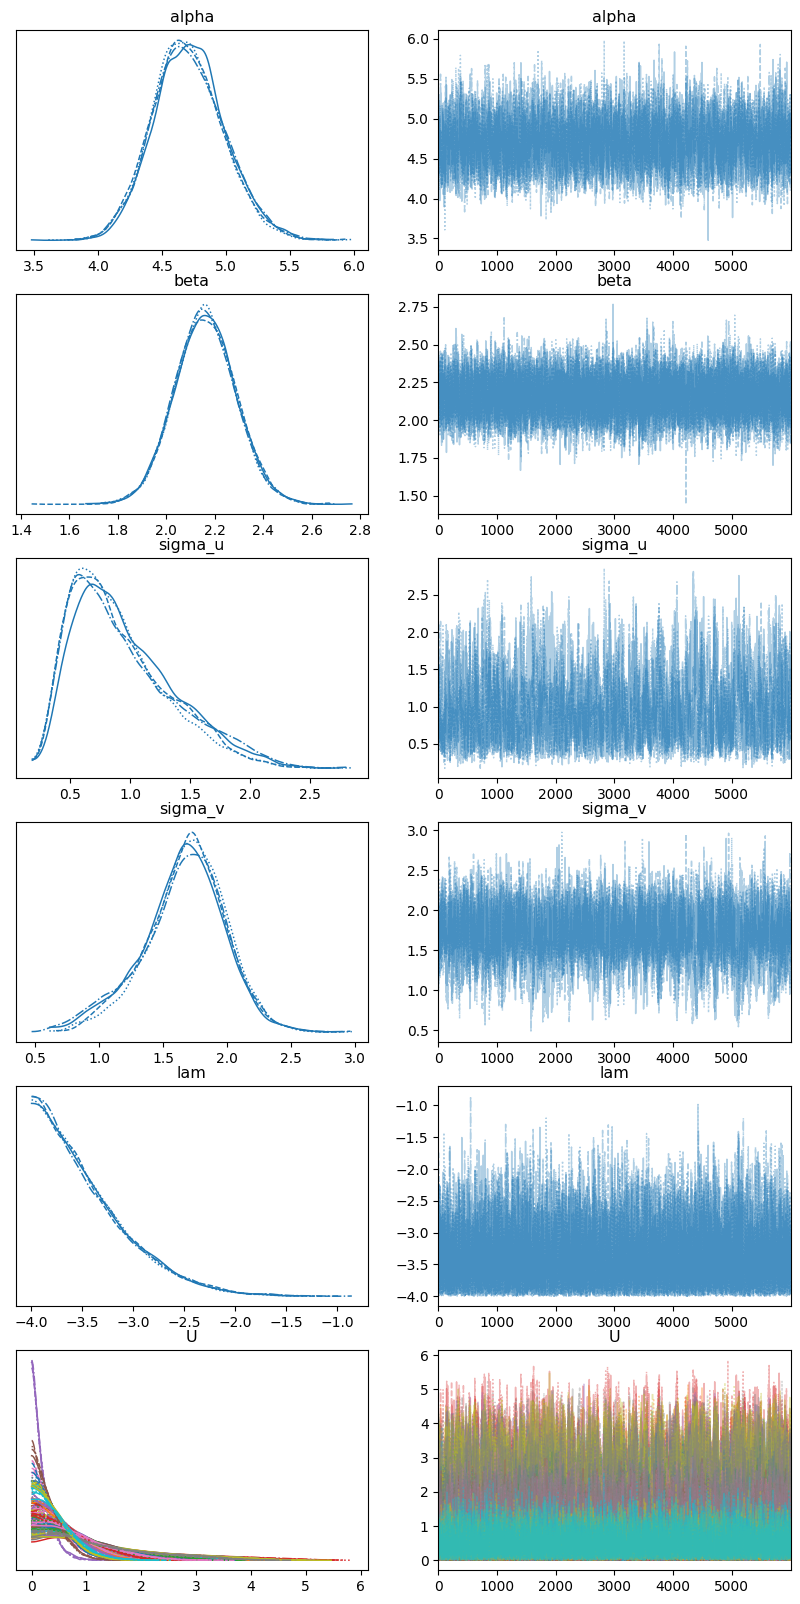

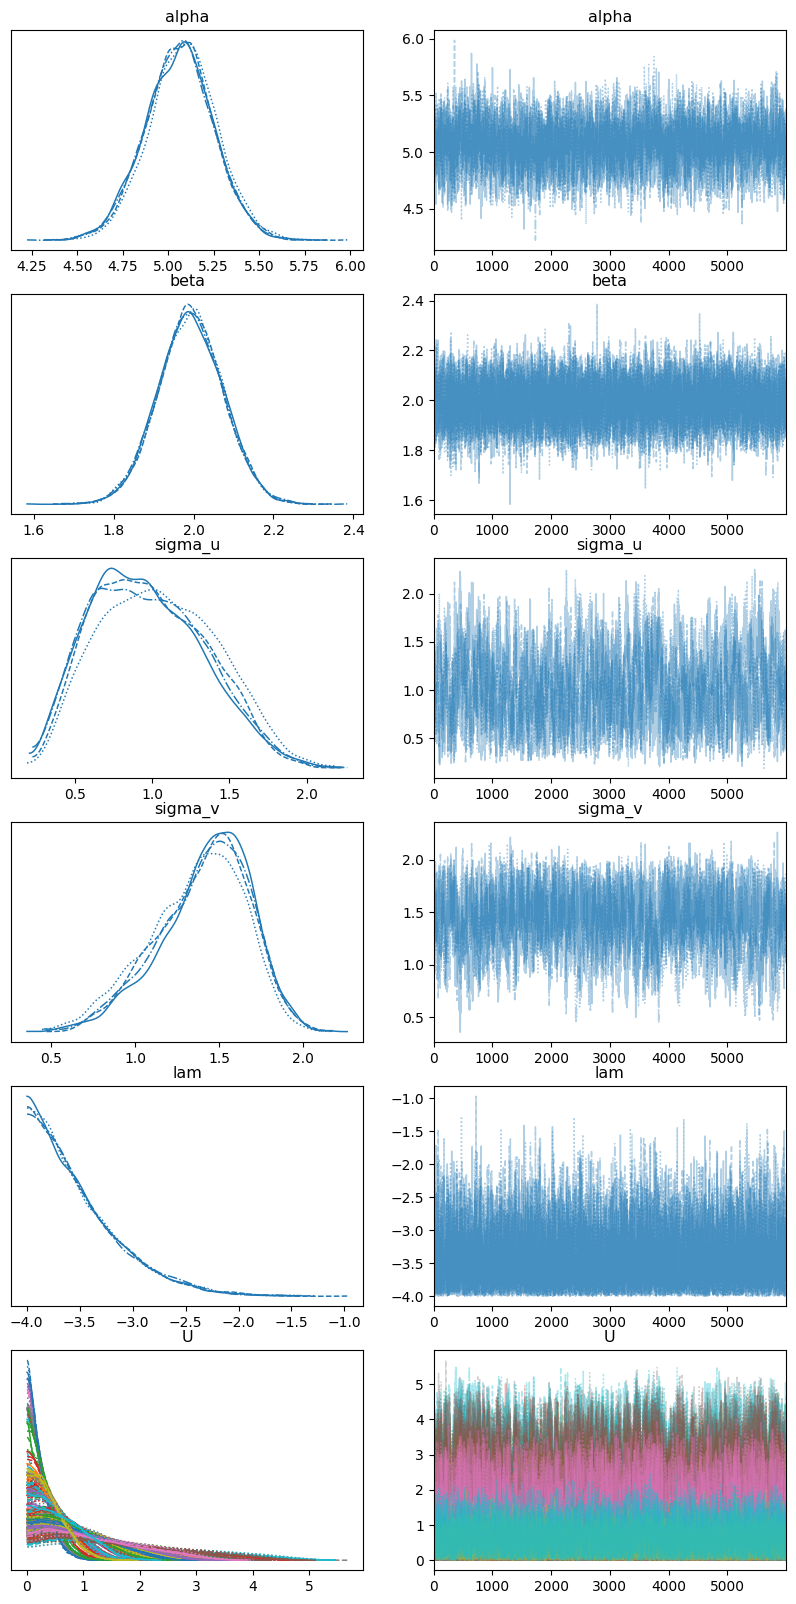

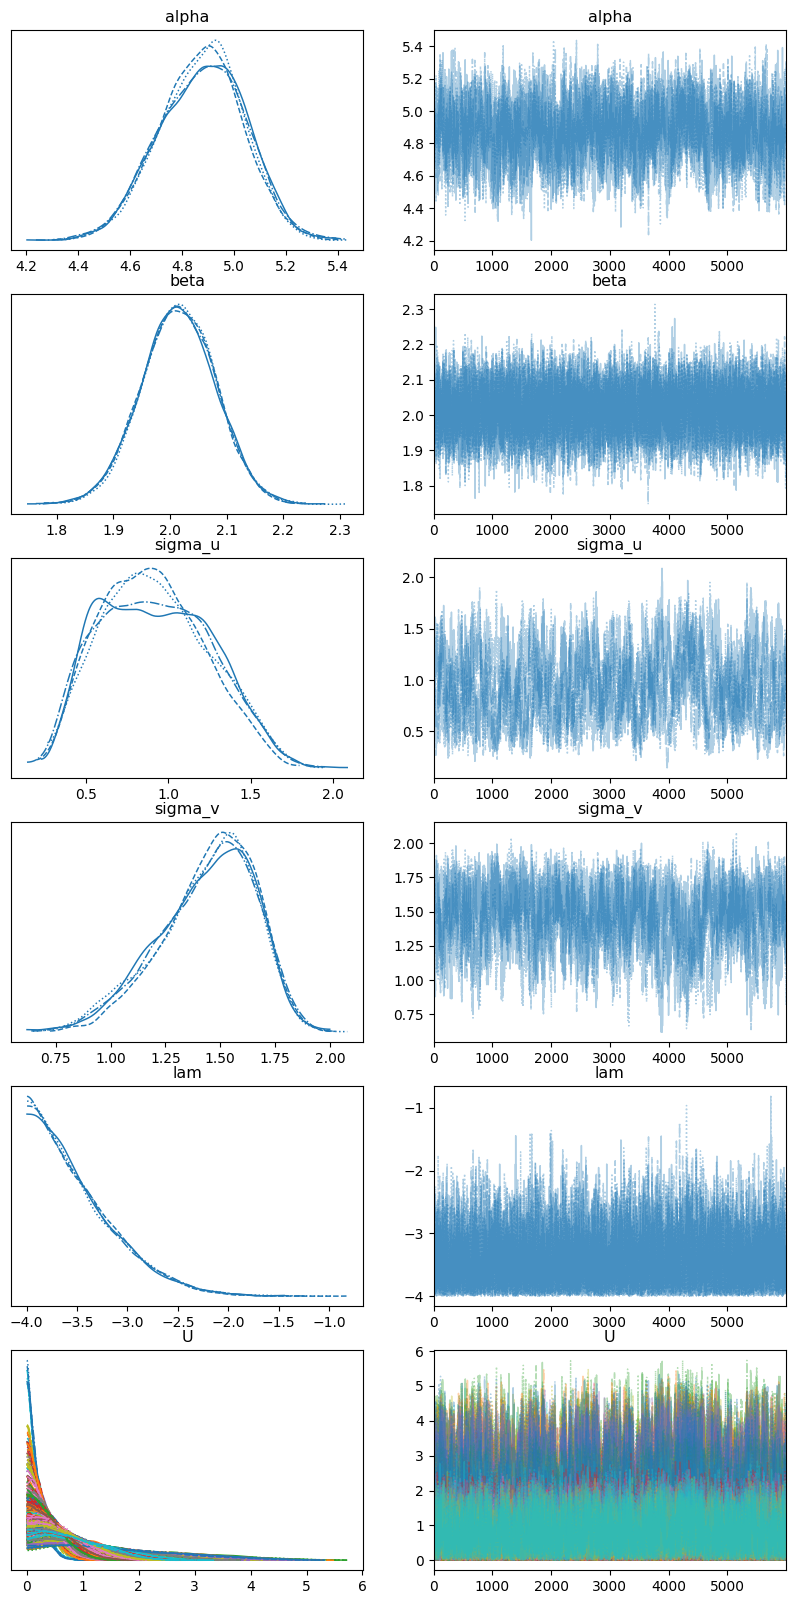

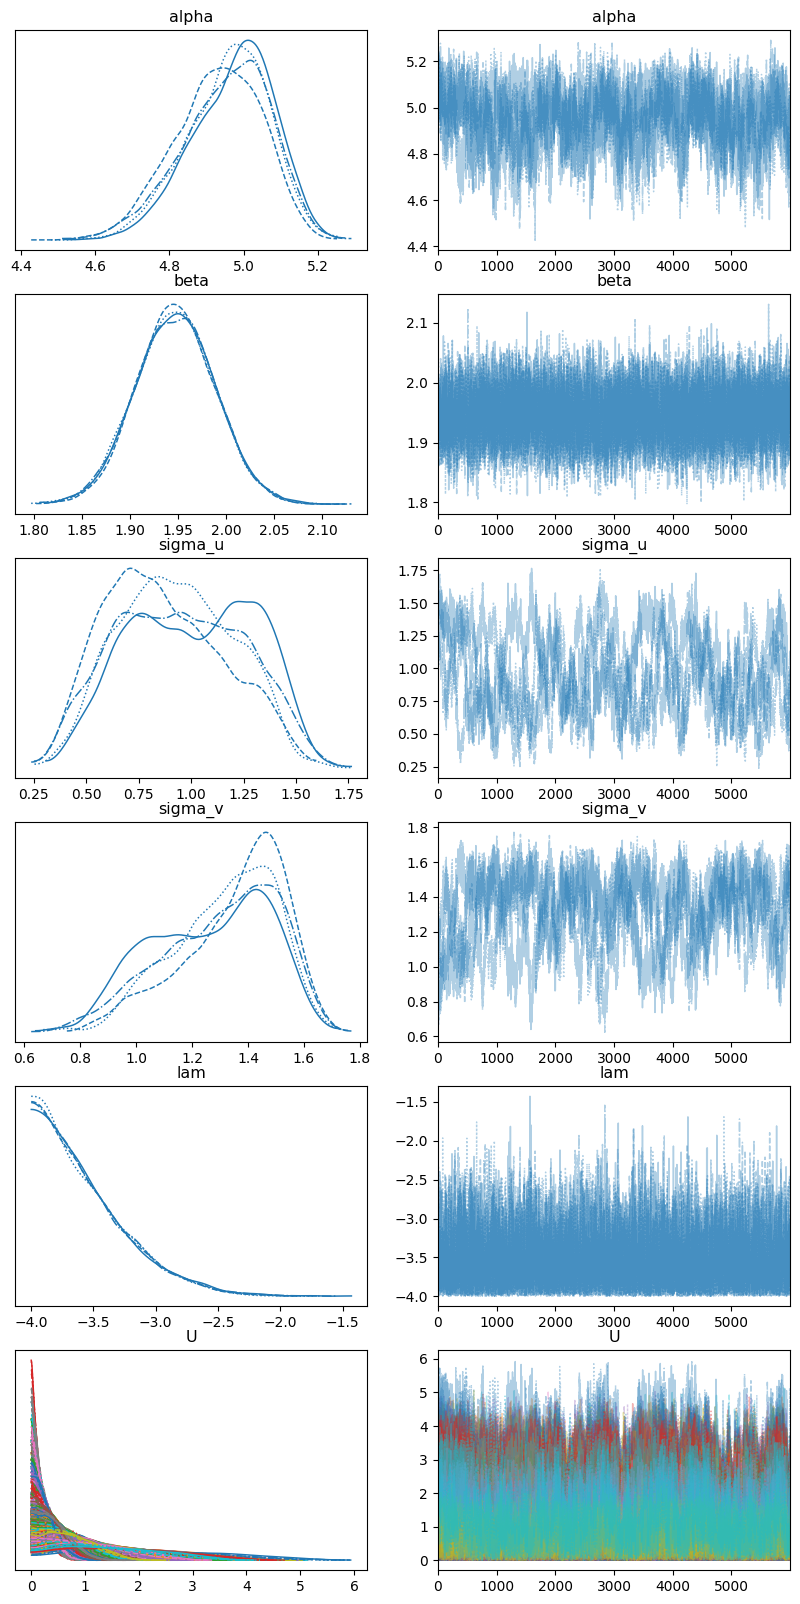

In [8]:
for i in range(4):  # Loop from 0 to 3
    print(f"Trace Skew {i + 1}")
    az.plot_trace(trace_skew[i][1], figsize=(10, 20))  # Use the second element (inference data)
    display(az.summary(trace_skew[i][1], round_to=2))  # Use the second element (inference data)

# Posterior Summaries: Normal

Trace Norm 1


mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha    3.55  0.42    2.79     4.32       0.01     0.00    866.23   2732.66   
beta     2.20  0.14    1.93     2.48       0.00     0.00  11272.07  14715.60   
sigma_u  1.12  0.45    0.35     1.88       0.02     0.00    776.82   2398.31   
sigma_v  0.98  0.23    0.53     1.36       0.01     0.00    925.97   2461.48   
U[0]     0.76  0.56    0.00     1.76       0.01     0.00   2832.89   9099.46   
U[1]     1.72  1.07    0.00     3.49       0.03     0.01    999.78   3653.59   
U[2]     1.27  0.84    0.00     2.72       0.02     0.01   1285.58   5444.83   
U[3]     2.04  1.25    0.00     4.06       0.04     0.01    906.78   3854.23   
U[4]     0.33  0.30    0.00     0.87       0.00     0.00  13777.42   9246.46   
U[5]     0.59  0.47    0.00     1.43       0.01     0.00   5079.14   7475.26   
U[6]     0.43  0.37    0.00     1.10       0.00     0.00  13149.77  11170.83   
U[7]     1.74  1.09    0.00     3.54       0.03     0.01   1025.77   3248.51   
U[8]     0.76  0.55    0.00     1.75       0.01     0.00   2539.24   5887.62   
U[9]     1.26  0.84    0.00     2.70       0.02     0.01   1282.32   5386.00   
U[10]    0.57  0.45    0.00     1.37       0.01     0.00   5504.02   9026.96   
U[11]    1.01  0.71    0.00     2.25       0.02     0.01   1645.49   5376.53   
U[12]    0.68  0.52    0.00     1.63       0.01     0.00   3534.37   7328.04   
U[13]    0.69  0.52    0.00     1.62       0.01     0.00   3373.64   7999.23   
U[14]    1.00  0.70    0.00     2.23       0.02     0.01   1647.05   5490.81   
U[15]    0.60  0.46    0.00     1.42       0.01     0.00   4493.17   7300.99   
U[16]    1.13  0.77    0.00     2.46       0.02     0.01   1447.05   4757.65   
U[17]    0.48  0.40    0.00     1.22       0.00     0.00  10879.01  10093.23   
U[18]    1.74  1.08    0.00     3.52       0.03     0.01   1050.93   3737.46   
U[19]    1.23  0.82    0.00     2.65       0.02     0.01   1310.29   5137.83   
U[20]    0.46  0.38    0.00     1.14       0.00     0.00  10684.63   8583.65   
U[21]    0.75  0.55    0.00     1.74       0.01     0.00   2955.12   7209.26   
U[22]    0.60  0.47    0.00     1.46       0.01     0.00   4721.64   8409.95   
U[23]    0.91  0.65    0.00     2.05       0.01     0.00   1930.76   6217.05   
U[24]    1.68  1.06    0.00     3.46       0.03     0.01    978.84   3289.96   
U[25]    0.70  0.52    0.00     1.63       0.01     0.00   3224.71   7501.81   
U[26]    0.67  0.51    0.00     1.59       0.01     0.00   3342.14   7278.87   
U[27]    0.47  0.39    0.00     1.18       0.00     0.00   9136.22   8988.17   
U[28]    0.66  0.50    0.00     1.56       0.01     0.00   3773.74   6914.63   
U[29]    0.88  0.64    0.00     2.03       0.01     0.01   1974.92   6765.22   
U[30]    1.03  0.71    0.00     2.28       0.02     0.01   1565.43   5276.14   
U[31]    0.84  0.64    0.00     1.99       0.01     0.01   2104.39   6372.50   
U[32]    1.09  0.76    0.00     2.42       0.02     0.01   1439.38   5409.31   
U[33]    0.56  0.44    0.00     1.36       0.01     0.00   5126.93   6758.55   
U[34]    0.70  0.53    0.00     1.64       0.01     0.00   3841.46   8229.99   
U[35]    0.87  0.62    0.00     1.97       0.01     0.00   2039.83   6962.51   
U[36]    0.59  0.46    0.00     1.43       0.01     0.00   4726.45   8345.14   
U[37]    1.75  1.09    0.00     3.53       0.03     0.01   1016.52   3892.29   
U[38]    1.74  1.09    0.00     3.52       0.04     0.01    979.86   3494.27   
U[39]    0.48  0.40    0.00     1.22       0.00     0.00   9515.88   9284.89   
U[40]    0.87  0.63    0.00     1.98       0.01     0.00   2026.97   7538.82   
U[41]    0.54  0.44    0.00     1.34       0.01     0.00   5206.15   7216.75   
U[42]    0.74  0.55    0.00     1.73       0.01     0.00   2748.38   7127.29   
U[43]    0.71  0.54    0.00     1.67       0.01     0.00   3020.63   7287.50   
U[44]    0.54  0.43    0.00     1.34       0.00     0.00   6635.35   8974.45   
U[45]    

Trace Norm 2


mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha    4.06  0.32    3.49     4.65       0.02     0.01    311.46   1144.56   
beta     1.99  0.09    1.83     2.17       0.00     0.00  13992.35  17006.76   
sigma_u  1.09  0.37    0.40     1.69       0.02     0.01    279.26    819.15   
sigma_v  0.84  0.18    0.52     1.16       0.01     0.00    326.25   1331.28   
U[0]     0.66  0.47    0.00     1.50       0.01     0.00   2106.27   8350.21   
...       ...   ...     ...      ...        ...      ...       ...       ...   
U[95]    2.10  1.09    0.07     3.82       0.06     0.01    355.67   1193.29   
U[96]    1.41  0.82    0.00     2.74       0.04     0.01    446.23   1931.24   
U[97]    0.45  0.36    0.00     1.11       0.00     0.00   9550.41   9206.98   
U[98]    0.44  0.35    0.00     1.08       0.00     0.00   8608.70  10422.96   
U[99]    0.63  0.46    0.00     1.45       0.01     0.00   2521.90   7645.90   

         r_hat  
alpha     1.02  
beta      1.00  
sigma_u   1.02  
sigma_v   1.01  
U[0]      1.00  
...        ...  
U[95]     1.01  
U[96]     1.01  
U[97]     1.00  
U[98]     1.00  
U[99]     1.00  

[104 rows x 9 columns]

Trace Norm 3


mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha    4.18  0.19    3.83     4.51       0.01     0.01    443.54    614.69   
beta     2.01  0.07    1.88     2.13       0.00     0.00   5849.57  13005.28   
sigma_u  1.42  0.22    1.03     1.82       0.01     0.01    382.74    509.39   
sigma_v  0.66  0.13    0.43     0.90       0.01     0.00    359.35    572.78   
U[0]     1.49  0.62    0.28     2.63       0.01     0.01   1792.34   2721.12   
...       ...   ...     ...      ...        ...      ...       ...       ...   
U[195]   0.56  0.41    0.00     1.28       0.00     0.00  14554.21   9367.77   
U[196]   0.76  0.46    0.00     1.55       0.00     0.00   8009.78   7716.47   
U[197]   0.99  0.53    0.00     1.84       0.01     0.00   2886.04   3876.73   
U[198]   0.85  0.50    0.00     1.69       0.01     0.00   4122.51   4087.45   
U[199]   1.13  0.56    0.04     2.06       0.01     0.00   2507.54   4757.23   

         r_hat  
alpha     1.02  
beta      1.00  
sigma_u   1.02  
sigma_v   1.02  
U[0]      1.00  
...        ...  
U[195]    1.00  
U[196]    1.00  
U[197]    1.00  
U[198]    1.00  
U[199]    1.00  

[204 rows x 9 columns]

Trace Norm 4


mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha    4.33  0.10    4.15     4.52       0.00     0.00    499.63    973.72   
beta     1.95  0.04    1.87     2.03       0.00     0.00   6399.59  12088.36   
sigma_u  1.42  0.12    1.20     1.62       0.01     0.01    459.31    827.92   
sigma_v  0.57  0.07    0.44     0.70       0.00     0.00    391.29    725.08   
U[0]     1.43  0.53    0.41     2.42       0.01     0.00   4587.25   5195.10   
...       ...   ...     ...      ...        ...      ...       ...       ...   
U[495]   0.40  0.31    0.00     0.96       0.00     0.00  14179.28   8023.10   
U[496]   1.82  0.55    0.75     2.84       0.01     0.01   2928.15   4045.52   
U[497]   0.46  0.34    0.00     1.07       0.00     0.00  14316.00   8638.73   
U[498]   0.88  0.46    0.01     1.64       0.00     0.00   9292.53   6762.42   
U[499]   2.55  0.57    1.48     3.61       0.01     0.01   2034.65   2447.27   

         r_hat  
alpha     1.01  
beta      1.00  
sigma_u   1.01  
sigma_v   1.01  
U[0]      1.00  
...        ...  
U[495]    1.00  
U[496]    1.00  
U[497]    1.00  
U[498]    1.00  
U[499]    1.00  

[504 rows x 9 columns]

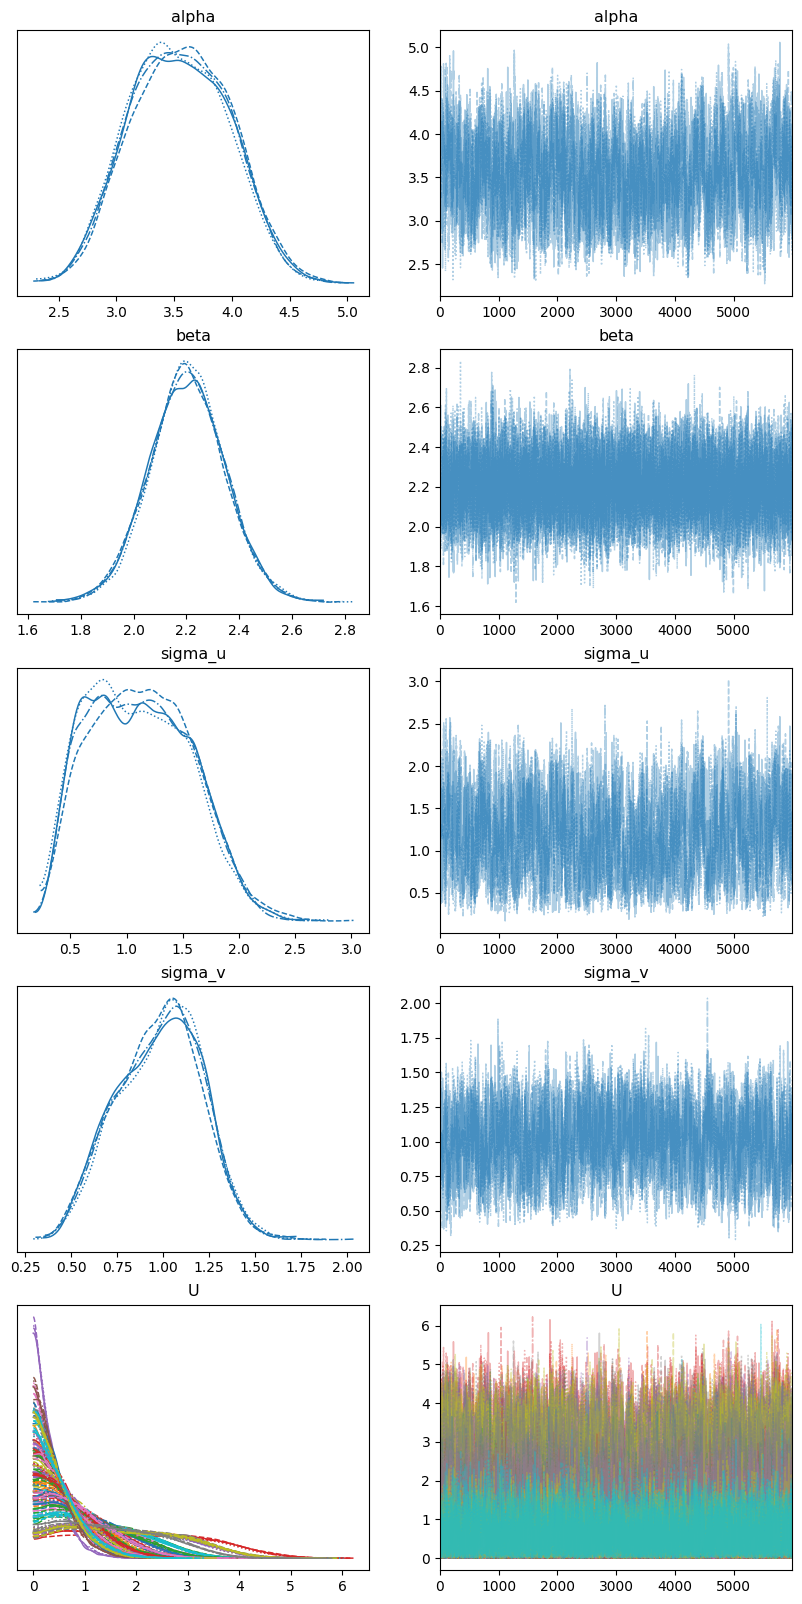

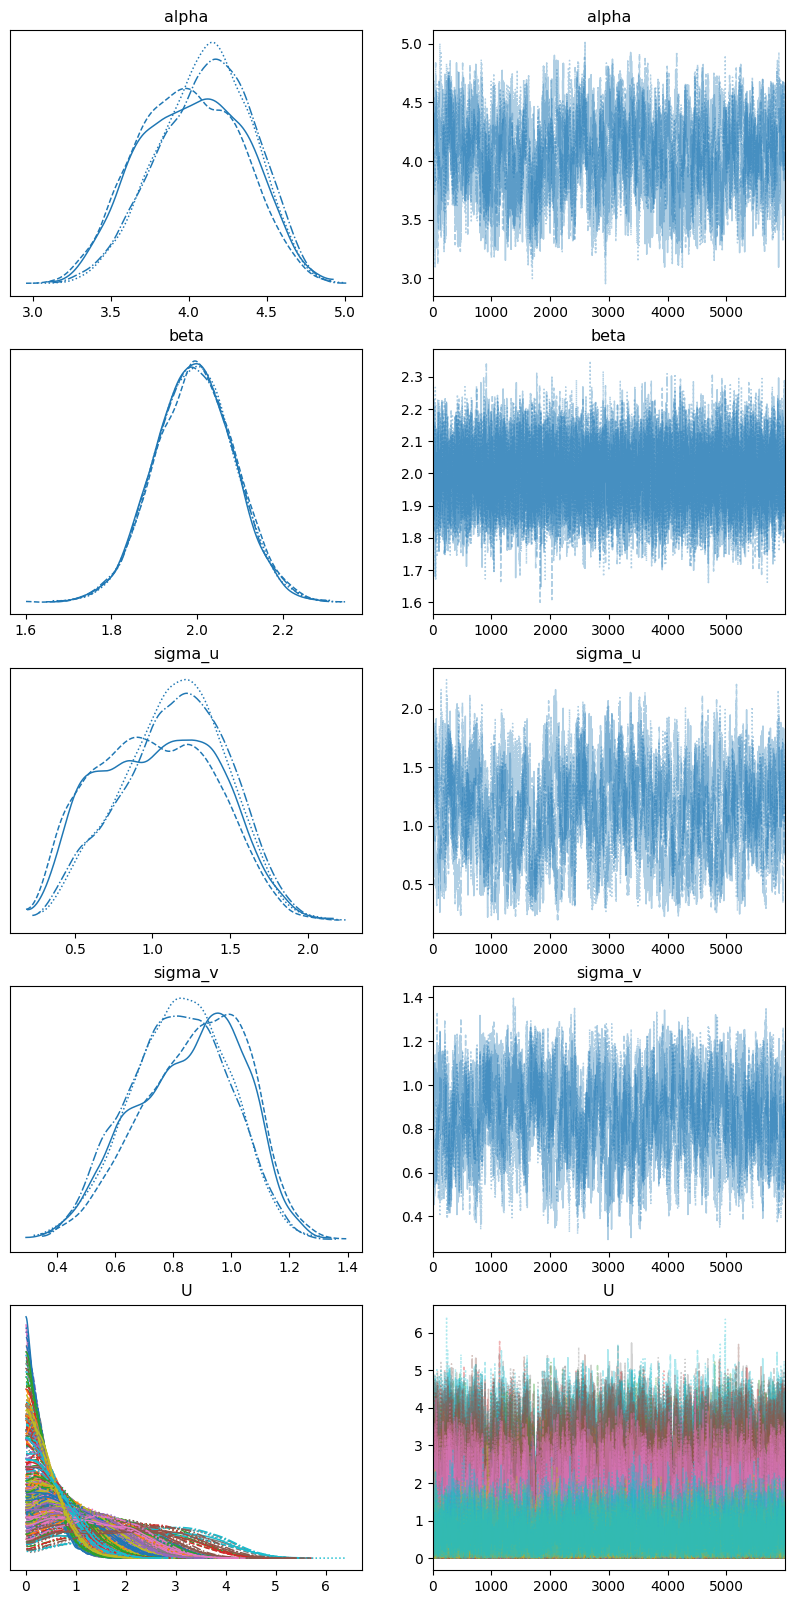

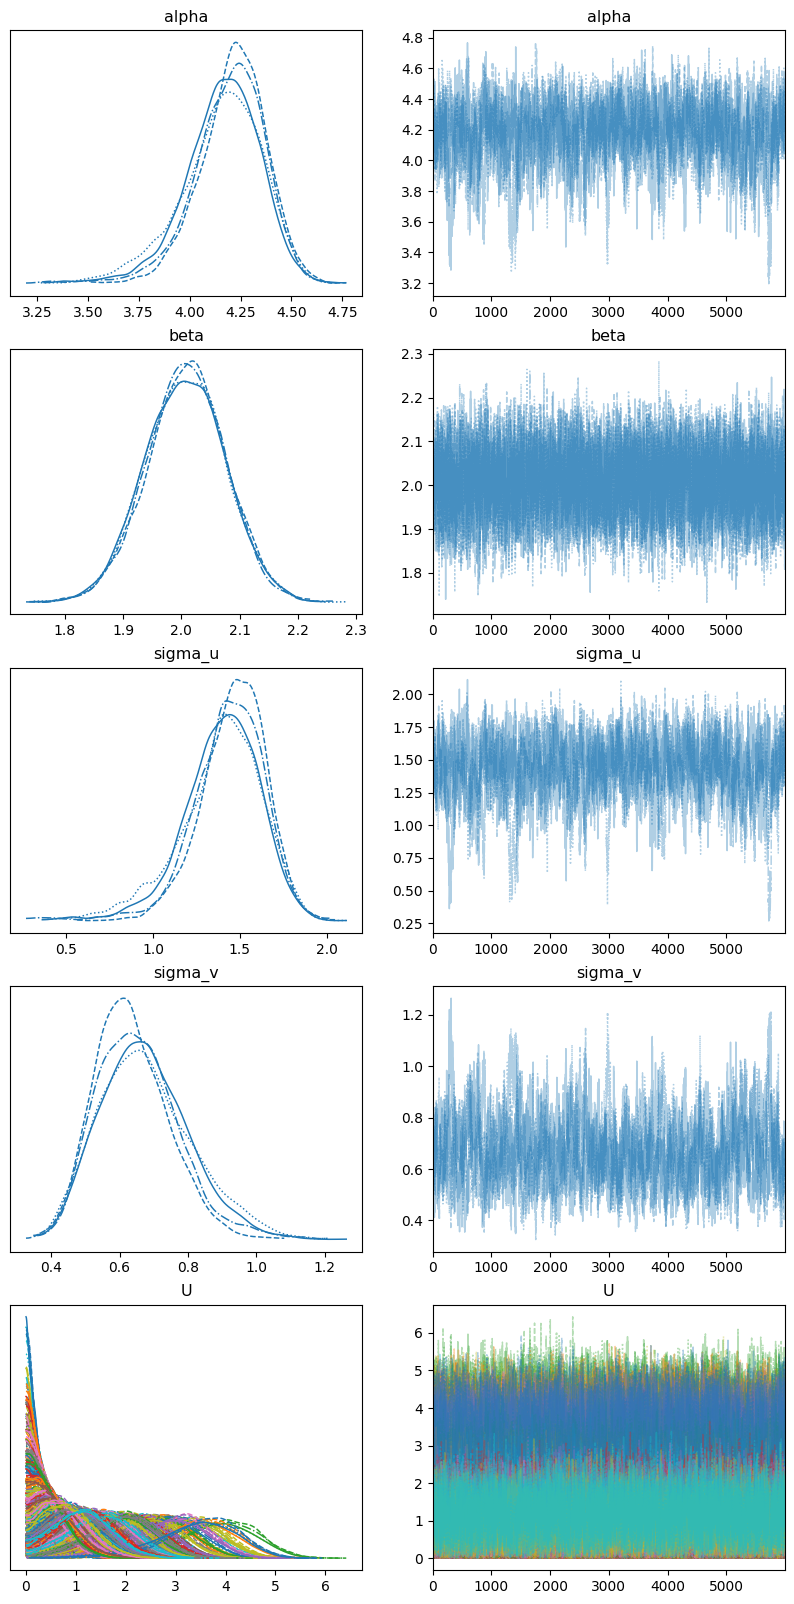

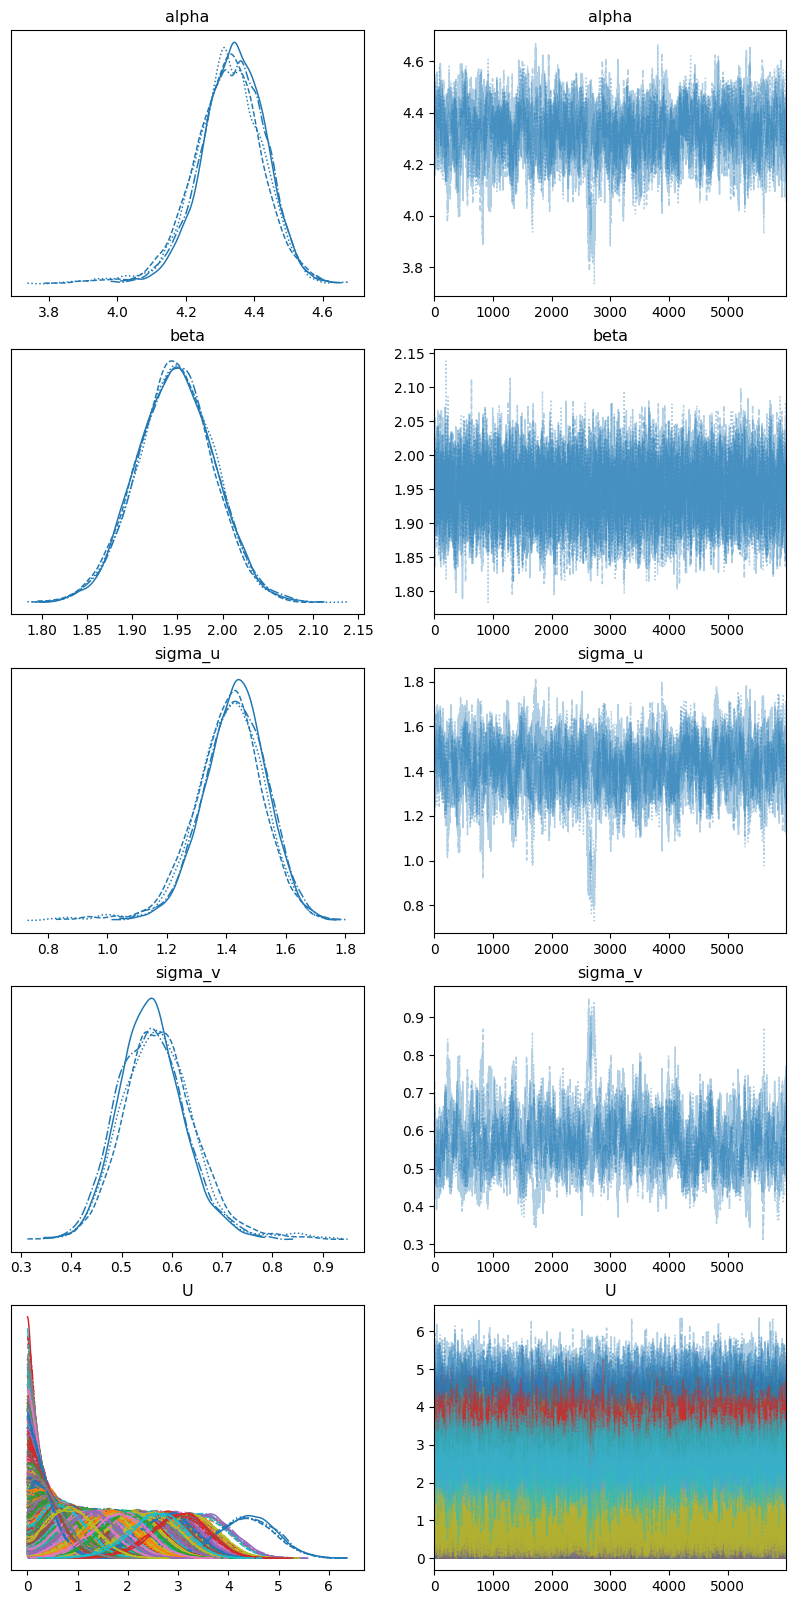

In [9]:
for i in range(4):  # Loop from 0 to 3
    print(f"Trace Norm {i + 1}")
    az.plot_trace(trace_norm[i][1], figsize=(10, 20))  # Use the second element (InferenceData)
    display(az.summary(trace_norm[i][1], round_to=2))  # Use the second element (InferenceData)

# Model Comparison

## Leave-One-Out (LOO)

In [10]:
for i in range(len(trace_skew)):  # Loop through the indices of trace_skew and trace_norm
    print(f"Comparison for sample size {sample_size[i]}:")
    df_comp_loo = az.compare({"Skew Normal": trace_skew[i][1], "Normal": trace_norm[i][1]})
    display(df_comp_loo)

Comparison for sample size 50:


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


rank   elpd_loo      p_loo  elpd_diff  weight        se  \
Skew Normal     0 -79.497250  14.491748   0.000000     1.0  4.929737   
Normal          1 -80.643333  19.987862   1.146083     0.0  4.470021   

                  dse  warning scale  
Skew Normal  0.000000     True   log  
Normal       1.240309     True   log

Comparison for sample size 100:


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/arviz/stats/stats.py:1045: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/arviz/stats/stats.py:1045: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/s

rank    elpd_loo      p_loo  elpd_diff  weight        se  \
Skew Normal     0 -145.513019  35.352071   0.000000     1.0  6.211925   
Normal          1 -148.529516  41.071153   3.016497     0.0  6.395865   

                  dse  warning scale  
Skew Normal  0.000000     True   log  
Normal       1.327803     True   log

Comparison for sample size 200:


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/arviz/stats/stats.py:1045: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/s

rank    elpd_loo       p_loo  elpd_diff        weight        se  \
Normal          0 -282.247664  115.552199   0.000000  1.000000e+00  8.725692   
Skew Normal     1 -291.213502   58.567760   8.965838  4.263256e-14  9.741290   

                  dse  warning scale  
Normal       0.000000     True   log  
Skew Normal  1.607503     True   log

Comparison for sample size 500:


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/arviz/stats/stats.py:1045: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/s

rank    elpd_loo       p_loo  elpd_diff        weight         se  \
Normal          0 -663.621840  312.653936   0.000000  1.000000e+00  12.906392   
Skew Normal     1 -689.320349  161.463362  25.698508  3.712586e-12  14.729735   

                  dse  warning scale  
Normal       0.000000     True   log  
Skew Normal  3.682914     True   log

## RMSE Parameter Estimates

In [11]:
true_vals_skew = np.array([5, 2, 1.5, 1, -5])
true_vals_norm = np.array([5, 2, 1.5, 1])
n_values = [50, 100, 200, 500]

for i in range(4):  # 0~3
    skew_summary = az.summary(trace_skew[i][1], var_names=["alpha", "beta", "sigma_v", "sigma_u", "lam"])
    norm_summary = az.summary(trace_norm[i][1], var_names=["alpha", "beta", "sigma_v", "sigma_u"])

    skew_means = skew_summary["mean"].values
    norm_means = norm_summary["mean"].values

    rmse_skew = np.sqrt((skew_means - true_vals_skew)**2)
    rmse_norm = np.sqrt((norm_means - true_vals_norm)**2)

    df = pd.DataFrame({
        "Parameter": ["alpha", "beta", "sigma_v", "sigma_u", "lambda"],
        "Skew Model RMSE": list(rmse_skew),
        "Normal Model RMSE": list(rmse_norm) + [np.nan]
    })

    print(f"\n RMSE Parameter Estimates (n = {n_values[i]})")
    display(df)



 RMSE Parameter Estimates (n = 50)


Parameter  Skew Model RMSE  Normal Model RMSE
0     alpha            0.295              1.451
1      beta            0.161              0.203
2   sigma_v            0.169              0.520
3   sigma_u            0.075              0.117
4    lambda            1.543                NaN


 RMSE Parameter Estimates (n = 100)


Parameter  Skew Model RMSE  Normal Model RMSE
0     alpha            0.066              0.938
1      beta            0.007              0.006
2   sigma_v            0.099              0.656
3   sigma_u            0.007              0.087
4    lambda            1.495                NaN


 RMSE Parameter Estimates (n = 200)


Parameter  Skew Model RMSE  Normal Model RMSE
0     alpha            0.124              0.820
1      beta            0.015              0.008
2   sigma_v            0.059              0.839
3   sigma_u            0.079              0.420
4    lambda            1.517                NaN


 RMSE Parameter Estimates (n = 500)


Parameter  Skew Model RMSE  Normal Model RMSE
0     alpha            0.047              0.671
1      beta            0.053              0.052
2   sigma_v            0.191              0.933
3   sigma_u            0.061              0.417
4    lambda            1.442                NaN

## RMSE Y_OBS

In [12]:
rmse_skew_list = []
rmse_norm_list = []

for i in range(4):  # corresponds to n=50, 100, 200, 500
    # Skew model
    with trace_skew[i][0]:
        ppc_skew = pm.sample_posterior_predictive(trace_skew[i][1], var_names=["Y_obs"])
    y_pred_skew = ppc_skew.posterior_predictive['Y_obs'].mean(dim=["chain", "draw"]).values
    y_obs_skew = trace_skew[i][1].observed_data['Y_obs'].values
    rmse_skew = np.sqrt(np.mean((y_obs_skew - y_pred_skew) ** 2))
    rmse_skew_list.append(rmse_skew)

    # Normal model
    with trace_norm[i][0]:
        ppc_norm = pm.sample_posterior_predictive(trace_norm[i][1], var_names=["Y_obs"])
    y_pred_norm = ppc_norm.posterior_predictive['Y_obs'].mean(dim=["chain", "draw"]).values
    y_obs_norm = trace_norm[i][1].observed_data['Y_obs'].values
    rmse_norm = np.sqrt(np.mean((y_obs_norm - y_pred_norm) ** 2))
    rmse_norm_list.append(rmse_norm)


for idx, n_val in enumerate([50, 100, 200, 500]):
    print(f"n = {n_val} → RMSE_Skew: {rmse_skew_list[idx]:.4f}, RMSE_Norm: {rmse_norm_list[idx]:.4f}")

Sampling: [Y_obs]


Output()

Sampling: [Y_obs]


Output()

Sampling: [Y_obs]


Output()

Sampling: [Y_obs]


Output()

Sampling: [Y_obs]


Output()

Sampling: [Y_obs]


Output()

Sampling: [Y_obs]


Output()

Sampling: [Y_obs]


Output()

n = 50 → RMSE_Skew: 0.9100, RMSE_Norm: 0.7732
n = 100 → RMSE_Skew: 0.7297, RMSE_Norm: 0.6572
n = 200 → RMSE_Skew: 0.7804, RMSE_Norm: 0.4243
n = 500 → RMSE_Skew: 0.6907, RMSE_Norm: 0.3403


## RMSE Ineffiency

In [13]:
import pandas as pd
from scipy.stats import halfnorm

rmse_u_skew_list = []
rmse_u_norm_list = []
n_values = [50, 100, 200, 500]

for i, n in enumerate(n_values):
    np.random.seed(123)
    U_true = halfnorm(scale=1).rvs(n)

    # Skew
    U_est_skew = trace_skew[i][1].posterior["U"].mean(dim=["chain", "draw"]).values
    rmse_u_skew = np.sqrt(np.mean((U_true - U_est_skew)**2))
    rmse_u_skew_list.append(rmse_u_skew)

    # Norm
    U_est_norm = trace_norm[i][1].posterior["U"].mean(dim=["chain", "draw"]).values
    rmse_u_norm = np.sqrt(np.mean((U_true - U_est_norm)**2))
    rmse_u_norm_list.append(rmse_u_norm)

# Make DataFrame
df_u_rmse = pd.DataFrame({
    "Sample Size (n)": n_values,
    "Skew Model RMSE (U)": rmse_u_skew_list,
    "Normal Model RMSE (U)": rmse_u_norm_list
})

display(df_u_rmse)


Sample Size (n)  Skew Model RMSE (U)  Normal Model RMSE (U)
0               50             0.792720               0.832527
1              100             0.754062               0.790907
2              200             0.706596               0.967085
3              500             0.681051               0.976679

# Metrics Container

In [8]:
# Metrics Containers

skew_container = {}
norm_container = {}

# Skew Summary Containers
skew_container[50] = az.summary(trace_skew[0][1])[['mean','sd','hdi_3%','hdi_97%','ess_bulk','ess_tail','r_hat']]
skew_container[100] = az.summary(trace_skew[1][1])[['mean','sd','hdi_3%','hdi_97%','ess_bulk','ess_tail','r_hat']]
skew_container[200] = az.summary(trace_skew[2][1])[['mean','sd','hdi_3%','hdi_97%','ess_bulk','ess_tail','r_hat']]
skew_container[500] = az.summary(trace_skew[3][1])[['mean','sd','hdi_3%','hdi_97%','ess_bulk','ess_tail','r_hat']]

# Normal Summary Containers
norm_container[50] = az.summary(trace_norm[0][1])[['mean','sd','hdi_3%','hdi_97%','ess_bulk','ess_tail','r_hat']]
norm_container[100] = az.summary(trace_norm[1][1])[['mean','sd','hdi_3%','hdi_97%','ess_bulk','ess_tail','r_hat']]
norm_container[200] = az.summary(trace_norm[2][1])[['mean','sd','hdi_3%','hdi_97%','ess_bulk','ess_tail','r_hat']]
norm_container[500] = az.summary(trace_norm[3][1])[['mean','sd','hdi_3%','hdi_97%','ess_bulk','ess_tail','r_hat']]

# LOO Container
loo = {}
loo[50] = az.compare({"Skew Normal": trace_skew[0][1], "Normal": trace_norm[0][1]})
loo[100] = az.compare({"Skew Normal": trace_skew[1][1], "Normal": trace_norm[1][1]})
loo[200] = az.compare({"Skew Normal": trace_skew[2][1], "Normal": trace_norm[2][1]})
loo[500] = az.compare({"Skew Normal": trace_skew[3][1], "Normal": trace_norm[3][1]})

# RMSE Parameter Container
rmse_param = {}

true_vals_skew = np.array([5, 2, 1.5, 1, -0.5])
true_vals_norm = np.array([5, 2, 1.5, 1])
n_values = [50, 100, 200, 500]
for i in range(4):  # 0~3
    skew_summary = az.summary(trace_skew[i][1], var_names=["alpha", "beta", "sigma_v", "sigma_u", "lam"])
    norm_summary = az.summary(trace_norm[i][1], var_names=["alpha", "beta", "sigma_v", "sigma_u"])

    skew_means = skew_summary["mean"].values
    norm_means = norm_summary["mean"].values

    rmse_skew = np.sqrt((skew_means - true_vals_skew)**2)
    rmse_norm = np.sqrt((norm_means - true_vals_norm)**2)

    df = pd.DataFrame({
        "Parameter": ["alpha", "beta", "sigma_v", "sigma_u", "lambda"],
        "Skew Model RMSE": list(rmse_skew),
        "Normal Model RMSE": list(rmse_norm) + [np.nan]
    })
    rmse_param[n_values[i]] = df

# RMSE Y_Obs Container
rmse_skew_list = []
rmse_norm_list = []

for i in range(4):  # corresponds to n=50, 100, 200, 500
    # Skew model
    with trace_skew[i][0]:
        ppc_skew = pm.sample_posterior_predictive(trace_skew[i][1], var_names=["Y_obs"])
    y_pred_skew = ppc_skew.posterior_predictive['Y_obs'].mean(dim=["chain", "draw"]).values
    y_obs_skew = trace_skew[i][1].observed_data['Y_obs'].values
    rmse_skew = np.sqrt(np.mean((y_obs_skew - y_pred_skew) ** 2))
    rmse_skew_list.append(rmse_skew)

    # Normal model
    with trace_norm[i][0]:
        ppc_norm = pm.sample_posterior_predictive(trace_norm[i][1], var_names=["Y_obs"])
    y_pred_norm = ppc_norm.posterior_predictive['Y_obs'].mean(dim=["chain", "draw"]).values
    y_obs_norm = trace_norm[i][1].observed_data['Y_obs'].values
    rmse_norm = np.sqrt(np.mean((y_obs_norm - y_pred_norm) ** 2))
    rmse_norm_list.append(rmse_norm)
    
pred_container = pd.DataFrame({
    'n': [50, 100, 200, 500],
    'Skew Model RMSE': rmse_skew_list,
    'Normal Model RMSE': rmse_norm_list    
})

# RMSE Ineffiency Container
rmse_u_skew_list = []
rmse_u_norm_list = []
n_values = [50, 100, 200, 500]

for i, n in enumerate(n_values):
    np.random.seed(123)
    U_true = halfnorm(scale=1).rvs(n)

    # Skew
    U_est_skew = trace_skew[i][1].posterior["U"].mean(dim=["chain", "draw"]).values
    rmse_u_skew = np.sqrt(np.mean((U_true - U_est_skew)**2))
    rmse_u_skew_list.append(rmse_u_skew)

    # Norm
    U_est_norm = trace_norm[i][1].posterior["U"].mean(dim=["chain", "draw"]).values
    rmse_u_norm = np.sqrt(np.mean((U_true - U_est_norm)**2))
    rmse_u_norm_list.append(rmse_u_norm)

# Make DataFrame
inefficiency_container = pd.DataFrame({
    "Sample Size (n)": n_values,
    "Skew Model RMSE (U)": rmse_u_skew_list,
    "Normal Model RMSE (U)": rmse_u_norm_list
})


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/arviz/stats/stats.py:1045: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importan

Output()

Sampling: [Y_obs]


Output()

Sampling: [Y_obs]


Output()

Sampling: [Y_obs]


Output()

Sampling: [Y_obs]


Output()

Sampling: [Y_obs]


Output()

Sampling: [Y_obs]


Output()

Sampling: [Y_obs]


Output()

In [10]:
loo[50]

rank   elpd_loo      p_loo  elpd_diff    weight        se  \
Skew Normal     0 -79.926865  14.038909   0.000000  0.817726  5.114603   
Normal          1 -80.842874  19.061790   0.916009  0.182274  4.502367   

                  dse  warning scale  
Skew Normal  0.000000     True   log  
Normal       1.736097     True   log

In [11]:
loo[100]

rank    elpd_loo      p_loo  elpd_diff        weight        se  \
Skew Normal     0 -142.699349  36.181723   0.000000  1.000000e+00  6.028381   
Normal          1 -148.326460  41.535821   5.627111  1.598721e-14  6.394618   

                  dse  warning scale  
Skew Normal  0.000000     True   log  
Normal       1.841601     True   log

In [12]:
loo[200]

rank    elpd_loo       p_loo  elpd_diff        weight        se  \
Normal          0 -286.805947  115.459748   0.000000  1.000000e+00  9.342616   
Skew Normal     1 -289.798763   55.541378   2.992817  3.108624e-15  9.695070   

               dse  warning scale  
Normal       0.000     True   log  
Skew Normal  1.979     True   log

In [13]:
loo[500]

rank    elpd_loo       p_loo  elpd_diff  weight         se  \
Normal          0 -657.225939  310.400526   0.000000     1.0  12.330975   
Skew Normal     1 -680.283396  164.879585  23.057457     0.0  14.387882   

                  dse  warning scale  
Normal       0.000000     True   log  
Skew Normal  4.102952     True   log

In [13]:
rmse_param

Parameter  Skew Model RMSE  Normal Model RMSE
0     alpha            0.177              1.469
1      beta            0.144              0.205
2   sigma_v            0.270              0.510
3   sigma_u            0.076              0.097
4    lambda            4.281                NaN

In [12]:
import pickle
num = [50, 100, 200, 500]
lam = -5
for i in num:
    with open('param.pkl', 'wb') as f:
        pickle.dump(rmse_param[i], f)
    with open('param.pkl', 'rb') as f:
        rmse_param = pickle.load(f)
    rmse_param[i].to_csv(f"{lam}rmse_param{i}.csv",index=True)

KeyError: 50

In [9]:
rmse_param[50]

Parameter  Skew Model RMSE  Normal Model RMSE
0     alpha            0.177              1.469
1      beta            0.144              0.205
2   sigma_v            0.270              0.510
3   sigma_u            0.076              0.097
4    lambda            4.281                NaN

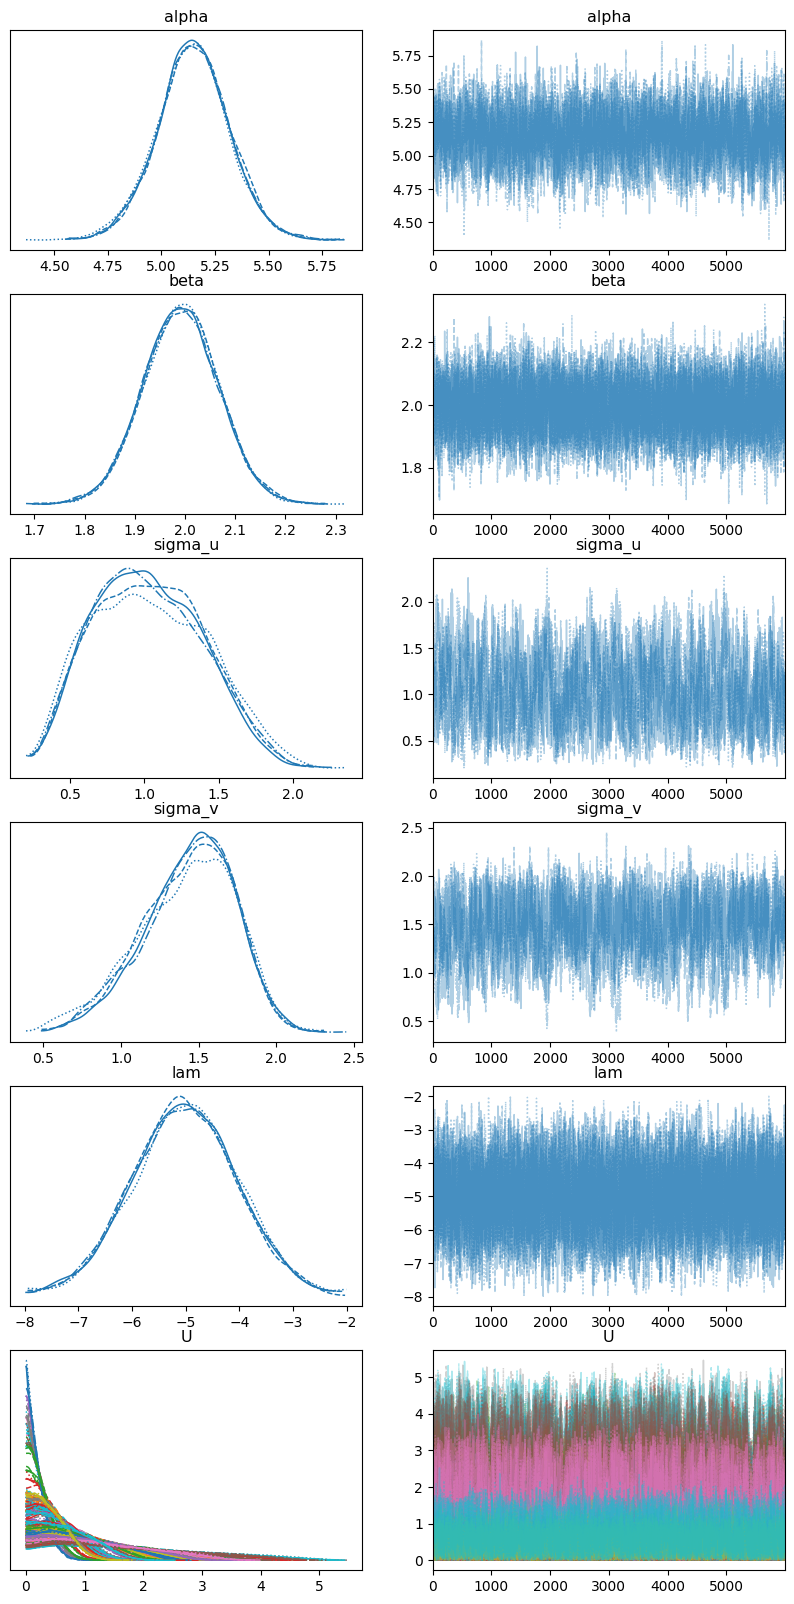

In [21]:
az.plot_trace(trace_skew[1][1], figsize=(10, 20));  # Use the second element (inference data)

In [14]:
rmse_param = {}

true_vals_skew = np.array([5, 2, 1.5, 1, -0.5])
true_vals_norm = np.array([5, 2, 1.5, 1])
n_values = [50, 100, 200, 500]
for i in range(4):  # 0~3
    skew_summary = az.summary(trace_skew[i][1], var_names=["alpha", "beta", "sigma_v", "sigma_u", "lam"])
    norm_summary = az.summary(trace_norm[i][1], var_names=["alpha", "beta", "sigma_v", "sigma_u"])

    skew_means = skew_summary["mean"].values
    norm_means = norm_summary["mean"].values

    rmse_skew = np.sqrt((skew_means - true_vals_skew)**2)
    rmse_norm = np.sqrt((norm_means - true_vals_norm)**2)

    df = pd.DataFrame({
        "Parameter": ["alpha", "beta", "sigma_v", "sigma_u", "lambda"],
        "Skew Model RMSE": list(rmse_skew),
        "Normal Model RMSE": list(rmse_norm) + [np.nan]
    })
    rmse_param[n_values[i]] = df

In [15]:
rmse_param

{50:   Parameter  Skew Model RMSE  Normal Model RMSE
 0     alpha            0.177              1.469
 1      beta            0.144              0.205
 2   sigma_v            0.270              0.510
 3   sigma_u            0.076              0.097
 4    lambda            4.281                NaN,
 100:   Parameter  Skew Model RMSE  Normal Model RMSE
 0     alpha            0.152              0.928
 1      beta            0.008              0.005
 2   sigma_v            0.072              0.662
 3   sigma_u            0.041              0.100
 4    lambda            4.525                NaN,
 200:   Parameter  Skew Model RMSE  Normal Model RMSE
 0     alpha            0.054              0.863
 1      beta            0.016              0.007
 2   sigma_v            0.008              0.811
 3   sigma_u            0.080              0.366
 4    lambda            4.140                NaN,
 500:   Parameter  Skew Model RMSE  Normal Model RMSE
 0     alpha            0.053              0.66